In [1]:
import argparse
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import scipy.io
import scipy.misc
import numpy as np
import pandas as pd
import PIL
import tensorflow as tf
from keras import backend as K
from keras.layers import Input, Lambda, Conv2D
from keras.models import load_model, Model
from yolo_utils import read_classes, read_anchors, generate_colors, preprocess_image, draw_boxes, scale_boxes
from yad2k.models.keras_yolo import yolo_head, yolo_boxes_to_corners, preprocess_true_boxes, yolo_loss, yolo_body

%matplotlib inline

Using TensorFlow backend.


In [69]:
image_file= "bbbb.jpg"
image= PIL.Image.open("images/"+image_file)
image_shape= (float(image.size[1]), float(image.size[0]))
print(image_shape)

(192.0, 263.0)


In [70]:
class_names = read_classes("model_data/coco_classes.txt")
anchors = read_anchors("model_data/yolo_anchors.txt")

In [71]:
yolo_model = load_model("model_data/yolo.h5")

In [72]:
yolo_outputs = yolo_head(yolo_model.output, anchors, len(class_names))

In [78]:
box_confidence, box_xy, box_wh, box_class_probs = yolo_outputs

In [74]:
def yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold = .6):
    """Filters YOLO boxes by thresholding on object and class confidence.
    
    Arguments:
    box_confidence -- tensor of shape (19, 19, 5, 1)
    boxes -- tensor of shape (19, 19, 5, 4)
    box_class_probs -- tensor of shape (19, 19, 5, 80)
    threshold -- real value, if [ highest class probability score < threshold], then get rid of the corresponding box
    
    Returns:
    scores -- tensor of shape (None,), containing the class probability score for selected boxes
    boxes -- tensor of shape (None, 4), containing (b_x, b_y, b_h, b_w) coordinates of selected boxes
    classes -- tensor of shape (None,), containing the index of the class detected by the selected boxes
    
    Note: "None" is here because you don't know the exact number of selected boxes, as it depends on the threshold. 
    For example, the actual output size of scores would be (10,) if there are 10 boxes.
    """
    
    # Step 1: Compute box scores
    ### START CODE HERE ### (≈ 1 line)
    box_scores = np.multiply(box_confidence, box_class_probs)
    ### END CODE HERE ###
    
    # Step 2: Find the box_classes thanks to the max box_scores, keep track of the corresponding score
    ### START CODE HERE ### (≈ 2 lines)
    box_classes = K.argmax(box_scores, axis=-1)
    box_class_scores = K.max(box_scores, axis=-1)
    ### END CODE HERE ###
    
    # Step 3: Create a filtering mask based on "box_class_scores" by using "threshold". The mask should have the
    # same dimension as box_class_scores, and be True for the boxes you want to keep (with probability >= threshold)
    ### START CODE HERE ### (≈ 1 line)
    filtering_mask = K.greater_equal(box_class_scores, threshold)
    ### END CODE HERE ###
    
    # Step 4: Apply the mask to scores, boxes and classes
    ### START CODE HERE ### (≈ 3 lines)
    scores = tf.boolean_mask(box_class_scores, filtering_mask)
    boxes = tf.boolean_mask(boxes, filtering_mask)
    classes = tf.boolean_mask(box_classes, filtering_mask)
    ### END CODE HERE ###
    
    return scores, boxes, classes

In [75]:
def yolo_non_max_suppression(scores, boxes, classes, max_boxes = 10, iou_threshold = 0.5):
    """
    Applies Non-max suppression (NMS) to set of boxes
    
    Arguments:
    scores -- tensor of shape (None,), output of yolo_filter_boxes()
    boxes -- tensor of shape (None, 4), output of yolo_filter_boxes() that have been scaled to the image size (see later)
    classes -- tensor of shape (None,), output of yolo_filter_boxes()
    max_boxes -- integer, maximum number of predicted boxes you'd like
    iou_threshold -- real value, "intersection over union" threshold used for NMS filtering
    
    Returns:
    scores -- tensor of shape (, None), predicted score for each box
    boxes -- tensor of shape (4, None), predicted box coordinates
    classes -- tensor of shape (, None), predicted class for each box
    
    Note: The "None" dimension of the output tensors has obviously to be less than max_boxes. Note also that this
    function will transpose the shapes of scores, boxes, classes. This is made for convenience.
    """
    
    max_boxes_tensor = K.variable(max_boxes, dtype='int32')     # tensor to be used in tf.image.non_max_suppression()
    K.get_session().run(tf.variables_initializer([max_boxes_tensor])) # initialize variable max_boxes_tensor
    
    # Use tf.image.non_max_suppression() to get the list of indices corresponding to boxes you keep
    ### START CODE HERE ### (≈ 1 line)
    nms_indices = tf.image.non_max_suppression(boxes, scores, max_boxes_tensor, iou_threshold=iou_threshold)

    ### END CODE HERE ###
    
    # Use K.gather() to select only nms_indices from scores, boxes and classes
    ### START CODE HERE ### (≈ 3 lines)
    scores = K.gather(scores, nms_indices)
    boxes = K.gather(boxes, nms_indices)
    classes = K.gather(classes, nms_indices)
    ### END CODE HERE ###
    
    return scores, boxes, classes

In [76]:
yolo_outputs
max_boxes=10
score_threshold=.6
iou_threshold=.5    
    
#box_confidence, box_xy, box_wh, box_class_probs = yolo_outputs

boxes = yolo_boxes_to_corners(box_xy, box_wh)

scores, boxes, classes = yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold = score_threshold)
    
boxes = scale_boxes(boxes, image_shape)

scores, boxes, classes = yolo_non_max_suppression(scores, boxes, classes, max_boxes = max_boxes, iou_threshold = iou_threshold)
    

Found 3 boxes for bbbb.jpg
[[ 99.52431   33.95383  127.930374  87.42155 ]
 [ 97.11064  174.94392  126.51422  233.56642 ]
 [ 98.10606  106.61141  129.93362  156.37894 ]]
car 0.75 (107, 98) (156, 130)
car 0.79 (175, 97) (234, 127)
car 0.83 (34, 100) (87, 128)


C:\Users\10650637\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  from ipykernel import kernelapp as app


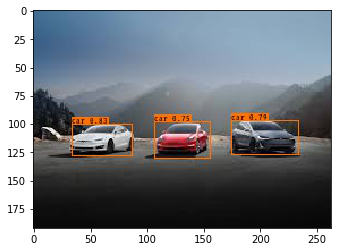

In [77]:
sess= K.get_session()
image, image_data = preprocess_image("images/"+image_file, model_image_size = (608, 608))

out_scores, out_boxes, out_classes = sess.run([scores, boxes, classes], feed_dict={yolo_model.input: image_data, K.learning_phase(): 0})
  
print('Found {} boxes for {}'.format(len(out_boxes), image_file))
    
print(out_boxes)
    
colors = generate_colors(class_names)
    
draw_boxes(image, out_scores, out_boxes, out_classes, class_names, colors)
  
image.save(os.path.join("out", image_file), quality=90)
output_image = scipy.misc.imread(os.path.join("out", image_file))
imshow(output_image)